## This file is for the penultimate development of this 4-Level Model

##### TRAINING SUBSECTION

In [1]:
'''NOTE Load in the training data for level-0 models'''

import _Data_Processing
import joblib
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X, X_train, X_val, X_ind,\
y, y_train, y_val, y_ind,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_large.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
	,optm_data	=		True
    ,indices	=		0
)
joblib.dump(scaler, 'scaler/tmp.joblib')

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 125400164 -> 64675164
loaded chunk 3 of size: 125400164 -> 64675164
loaded chunk 4 of size: 125400164 -> 64675164
loaded chunk 5 of size: 125400164 -> 64675164
loaded chunk 6 of size: 125400164 -> 64675164
loaded chunk 7 of size: 125400164 -> 64675164
loaded chunk 8 of size: 125400164 -> 64675164
loaded chunk 9 of size: 125400164 -> 64675164
loaded chunk 10 of size: 125400164 -> 64675164
loaded chunk 11 of size: 125400164 -> 64575164
loaded chunk 12 of size: 125400164 -> 64675164
loaded chunk 13 of size: 125400164 -> 64675164
loaded chunk 14 of size: 111646292 -> 57581610
concat chunks
concatted chunks
Success.
Size of dataset:	898356610
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success...

# of Samples:	347258

# of Features:	519

Target:		tc_2a_60m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature nam

['scaler/tmp.joblib']

In [7]:
'''NOTE Shred the data to run parallel to desired level-0 structure'''

import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
	,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.85
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	True
	,filter_type	=	'Retention'
	,filter_value	=	0.95
	,n_sample_parts	=	1
	,smpl_part_type	=	'Even'
	,sample_overlap	=	0.9
	,sample_shuffle	=	False
	,lstm_format	=	lstm_format
)

Custom parameters selected.
nn	-	{'optimizer_type': 'Adam', 'optimizer_kwarg': {'learning_rate': 0.00025}, 'time_steps': 5, 'LSTM': False, 'shuffle_train': True, 'epochs': 7, 'rlr_patience': 20, 'architecture': 'default_deep'}
Running on: GPU

Training model #1
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5022 - loss: 0.8526 - precision: 0.5069 - recall: 0.5262 - val_accuracy: 0.4983 - val_loss: 0.7110 - val_precision: 0.5379 - val_recall: 0.4971 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5074 - loss: 0.7508 - precision: 0.5187 - recall: 0.5385 - val_accuracy: 0.5043 - val_loss: 0.7034 - val_precision: 0.5627 - val_recall: 0.3646 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5076 - loss: 0.7203 - precision: 0.5148 - recall: 0.5314 - val_accuracy: 0.5054 - val_loss: 0.6996 - val_precision: 0.5585 - val_recall: 0.3971 - learning_rate: 2.5000e-04
Epoch 4/7

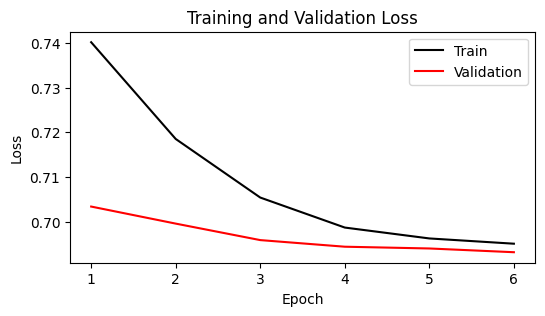

Running on: GPU

Training model #2
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5022 - loss: 0.8425 - precision: 0.5166 - recall: 0.5186 - val_accuracy: 0.5022 - val_loss: 0.7091 - val_precision: 0.5343 - val_recall: 0.6026 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5050 - loss: 0.7436 - precision: 0.5130 - recall: 0.5062 - val_accuracy: 0.5224 - val_loss: 0.6962 - val_precision: 0.5450 - val_recall: 0.6951 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5022 - loss: 0.7179 - precision: 0.5133 - recall: 0.5262 - val_accuracy: 0.5086 - val_loss: 0.6976 - val_precision: 0.5387 - val_recall: 0.6215 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5090 - loss: 0.7063 - precision: 0.5191 - recall: 0.5275 - val_accuracy: 0.5000 - val_loss: 0.6951 - val_precision: 0.5343 - val_recall: 0.5708 - learning_rate: 2.5000e-04

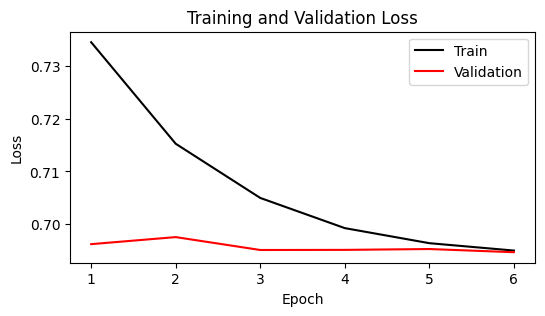

Running on: GPU

Training model #3
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4982 - loss: 0.8482 - precision: 0.5084 - recall: 0.5630 - val_accuracy: 0.5397 - val_loss: 0.7060 - val_precision: 0.5461 - val_recall: 0.8685 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4982 - loss: 0.7486 - precision: 0.5061 - recall: 0.5191 - val_accuracy: 0.5391 - val_loss: 0.6928 - val_precision: 0.5475 - val_recall: 0.8404 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5055 - loss: 0.7153 - precision: 0.5133 - recall: 0.5153 - val_accuracy: 0.5492 - val_loss: 0.6869 - val_precision: 0.5597 - val_recall: 0.7707 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5065 - loss: 0.7045 - precision: 0.5165 - recall: 0.5152 - val_accuracy: 0.5552 - val_loss: 0.6864 - val_precision: 0.5655 - val_recall: 0.7581 - learning_rate: 2.5000e-04


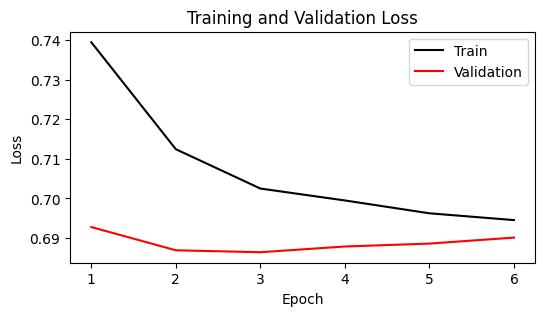

Running on: GPU

Training model #4
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4944 - loss: 0.7581 - precision: 0.5072 - recall: 0.4582 - val_accuracy: 0.4859 - val_loss: 0.7009 - val_precision: 0.5288 - val_recall: 0.4326 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4987 - loss: 0.7152 - precision: 0.5148 - recall: 0.4740 - val_accuracy: 0.4801 - val_loss: 0.6978 - val_precision: 0.5247 - val_recall: 0.3869 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4986 - loss: 0.7063 - precision: 0.5095 - recall: 0.4472 - val_accuracy: 0.4818 - val_loss: 0.6956 - val_precision: 0.5310 - val_recall: 0.3389 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5102 - loss: 0.6976 - precision: 0.5189 - recall: 0.4643 - val_accuracy: 0.4808 - val_loss: 0.6944 - val_precision: 0.5298 - val_recall: 0.3348 - learning_rate: 2.5000e-04


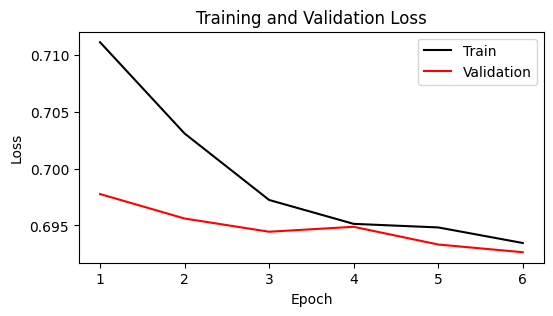

Running on: GPU

Training model #5
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5027 - loss: 0.8485 - precision: 0.5121 - recall: 0.5050 - val_accuracy: 0.5402 - val_loss: 0.7043 - val_precision: 0.5673 - val_recall: 0.6230 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4990 - loss: 0.7613 - precision: 0.5068 - recall: 0.4979 - val_accuracy: 0.5408 - val_loss: 0.6972 - val_precision: 0.5848 - val_recall: 0.5138 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5063 - loss: 0.7249 - precision: 0.5125 - recall: 0.5209 - val_accuracy: 0.5387 - val_loss: 0.6930 - val_precision: 0.5940 - val_recall: 0.4585 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5046 - loss: 0.7120 - precision: 0.5146 - recall: 0.5172 - val_accuracy: 0.5395 - val_loss: 0.6932 - val_precision: 0.6053 - val_recall: 0.4212 - learning_rate: 2.5000e-04


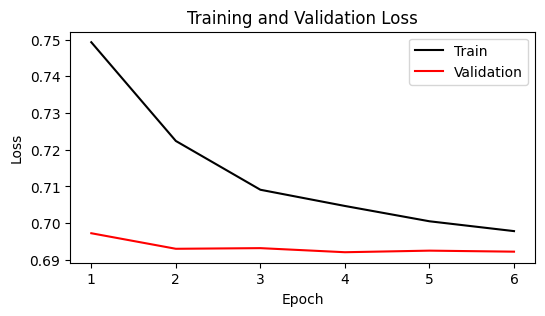

Running on: GPU

Training model #6
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5010 - loss: 0.8538 - precision: 0.5113 - recall: 0.4790 - val_accuracy: 0.4702 - val_loss: 0.7595 - val_precision: 0.5304 - val_recall: 0.1567 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5028 - loss: 0.7567 - precision: 0.5134 - recall: 0.4980 - val_accuracy: 0.4830 - val_loss: 0.7139 - val_precision: 0.5540 - val_recall: 0.2140 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5079 - loss: 0.7246 - precision: 0.5190 - recall: 0.5090 - val_accuracy: 0.4848 - val_loss: 0.7042 - val_precision: 0.5568 - val_recall: 0.2210 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5059 - loss: 0.7119 - precision: 0.5119 - recall: 0.5063 - val_accuracy: 0.4970 - val_loss: 0.6983 - val_precision: 0.5679 - val_recall: 0.2829 - learning_rate: 2.5000e-04


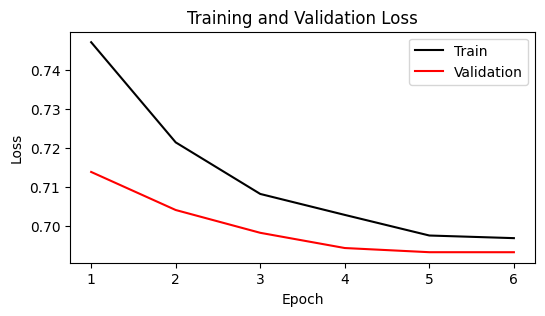

Running on: GPU

Training model #7
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5038 - loss: 0.8978 - precision: 0.5148 - recall: 0.4965 - val_accuracy: 0.4881 - val_loss: 0.7286 - val_precision: 0.5389 - val_recall: 0.3542 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5049 - loss: 0.7627 - precision: 0.5117 - recall: 0.5007 - val_accuracy: 0.5058 - val_loss: 0.6997 - val_precision: 0.5532 - val_recall: 0.4362 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5082 - loss: 0.7268 - precision: 0.5173 - recall: 0.5071 - val_accuracy: 0.5047 - val_loss: 0.6953 - val_precision: 0.5549 - val_recall: 0.4141 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4967 - loss: 0.7169 - precision: 0.5068 - recall: 0.4878 - val_accuracy: 0.5233 - val_loss: 0.6929 - val_precision: 0.5721 - val_recall: 0.4619 - learning_rate: 2.5000e-04


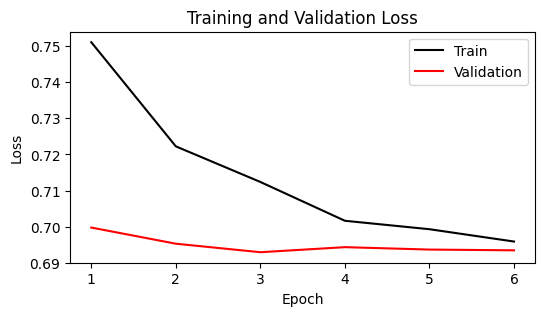

Running on: GPU

Training model #8
Running on: GPU

Epoch 1/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5028 - loss: 0.7779 - precision: 0.5134 - recall: 0.4863 - val_accuracy: 0.4870 - val_loss: 0.7045 - val_precision: 0.5703 - val_recall: 0.1997 - learning_rate: 2.5000e-04
Epoch 2/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5038 - loss: 0.7179 - precision: 0.5147 - recall: 0.4907 - val_accuracy: 0.4772 - val_loss: 0.7037 - val_precision: 0.5865 - val_recall: 0.1053 - learning_rate: 2.5000e-04
Epoch 3/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5025 - loss: 0.7054 - precision: 0.5134 - recall: 0.4852 - val_accuracy: 0.4772 - val_loss: 0.6987 - val_precision: 0.5724 - val_recall: 0.1228 - learning_rate: 2.5000e-04
Epoch 4/7
944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5080 - loss: 0.6989 - precision: 0.5161 - recall: 0.4898 - val_accuracy: 0.4791 - val_loss: 0.6978 - val_precision: 0.5934 - val_recall: 0.1094 - learning_rate: 2.5000e-04


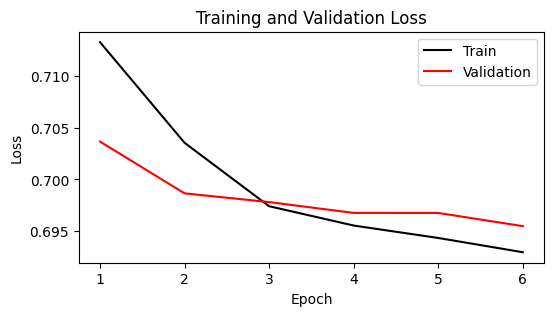

In [8]:
'''NOTE Begin training for each level-0 model'''

import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
	Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
	Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
	model_types	=	['nn']
	,data_parts	=	X_train_parts
	,findx_parts=	X_find_parts
	,trans_parts=	X_trans_parts
	,trgt_parts	=	y_parts
	,X_valid	=	X_val
	,y_valid	=	y_val
	,param_mode	=	'custom'
	,cst_mod_prm=	[{
		'optimizer_type'	:	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.00025
			#,'momentum'		:	0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	7
		,'rlr_patience'		:	20
		,'architecture'	:	'default_deep'
		#,'external_cw'	:	_Utility.get_class_weights(y_train)
		}]
	,tnr_verbose=	True
	,lstm_frmt	=	lstm_format
	,use_cls_wt	=	True
)

In [9]:
'''NOTE show performances of level-0 Models'''

import _Model_Evaluation
import _Neural_Net

reload(_Model_Evaluation)
reload(_Neural_Net)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
		,lstm_frmt	=	lstm_format
)

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Dimensions of Trained Models:
	Feature Space: 8
	Sample Space: 1
	Model Space: 1


	Displaying all performances for all independent samples: (8 cases)

4

Statistics Overall:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.02	0.49	0.56
		Precision	0.58	0.02	0.54	0.61
		Recall		0.45	0.18	0.2	0.76

Statistics By Feature Space:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.0	0.54	0.54
		Precision	0.59	0.0	0.59	0.59
		Recall		0.44	0.0	0.44	0.44
	Split 1:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.0	0.52	0.52
		Precision	0.54	0.0	0.54	0.54
		Recall		0.7	0.0	0.7	0.7
	Split 2:
				Avg	St.Dv.	Low	High
		Accuracy	0.56	0.0	0.56	0.56
		Precision	0.57	0.0	0.57	0.57

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(7640, 8)
Running on: GPU

Running on: GPU

Epoch 1/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5125 - loss: 0.7722 - precision: 0.5704 - recall: 0.5112 - val_accuracy: 0.5412 - val_loss: 0.7050 - val_precision: 0.5563 - val_recall: 0.5058 - learning_rate: 2.5000e-04
Epoch 2/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5182 - loss: 0.7484 - precision: 0.5641 - recall: 0.5004 - val_accuracy: 0.5432 - val_loss: 0.7047 - val_precision: 0.5587 - val_recall: 0.5058 - learning_rate: 2.5000e-04
Epoch 3/75
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5036 - loss: 0.7441 - precision: 0.5526 - recall: 0.4742 - val_accuracy: 0.5425 - val_

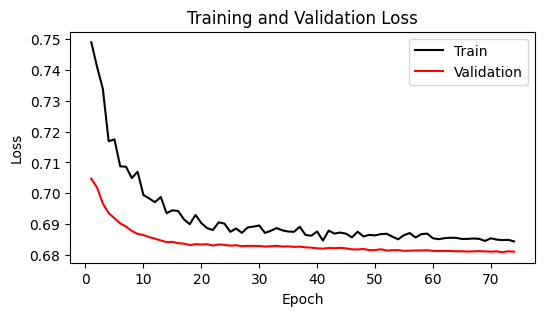

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
META-MODEL SELF TEST:
	Accuracy:	0.55
	Precision:	0.62
	Recall:		0.49


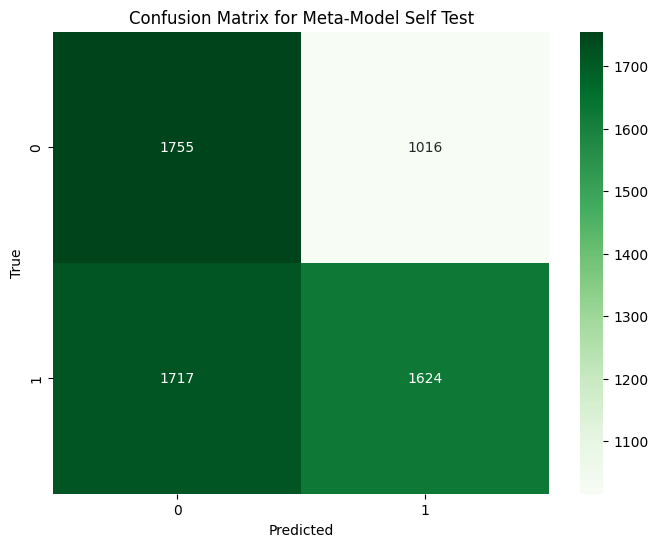

META-MODEL INDEPENDENT TEST:
	Accuracy:	0.59
	Precision:	0.62
	Recall:		0.54


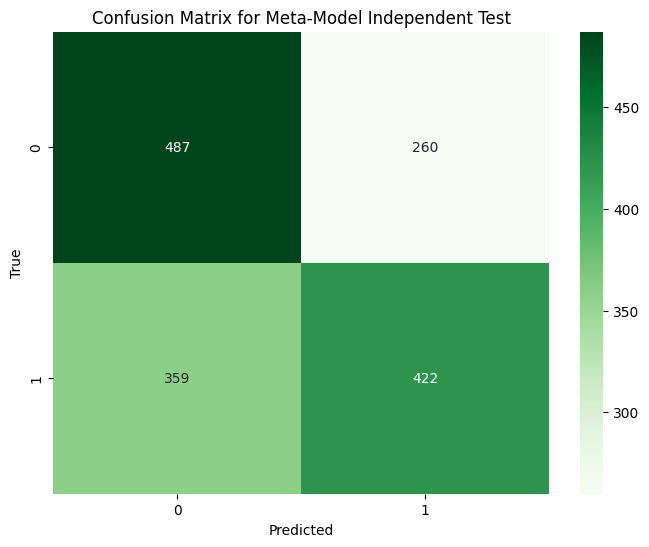

In [12]:
'''NOTE begin training for level-1 model based off of train level-0 model predictions'''

import _Metamodel
from importlib import reload
import _Utility

reload(_Metamodel)

metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models		=	models
	,X_findx	=	X_find_parts
	,X_trans	=	X_trans_parts
	,X_test		=	X_val
	,y_test		=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type =	'NN'
	,use_cls_wt =	True
	,use_mm_params=	True
    ,meta_scaler=	'Standard'
	,metam_params={
		'optimizer_type':	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.00025
            #,'weight_decay'	:	0.001
			#,'momentum':0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	75
		,'batch_size'		:	30
		,'rlr_patience'		:	10
		,'architecture'	:	'default_deep'
		#,'custom_val_data'	:	(X_train, y_train)
		}
)

In [13]:
'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
lstm_format = False
X_test, _, _, __,\
y_test, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,indices	=		0
)

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success...

# of Samples:	21571

# of Features:	519

Target:		tc_2a_60m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training featurespace...Success.
Trying to drop unwanted time-range samples...Success.
	19096 Samples Dropped.

Trying to split X and y into Train/Validation/Independent...Success.
Trying to clean up...Success.
X_train:	(2425, 519).
y_train:	(2425,).
X_val:  	(25, 519).
y_val:  	(25,).
X_ind:  	(25, 519).
y_ind:  	(25,).
Terminating.


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(7640, 8)
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


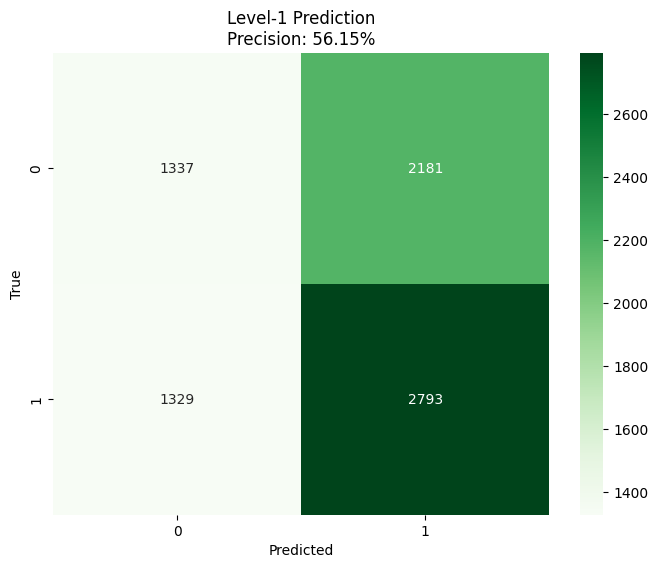

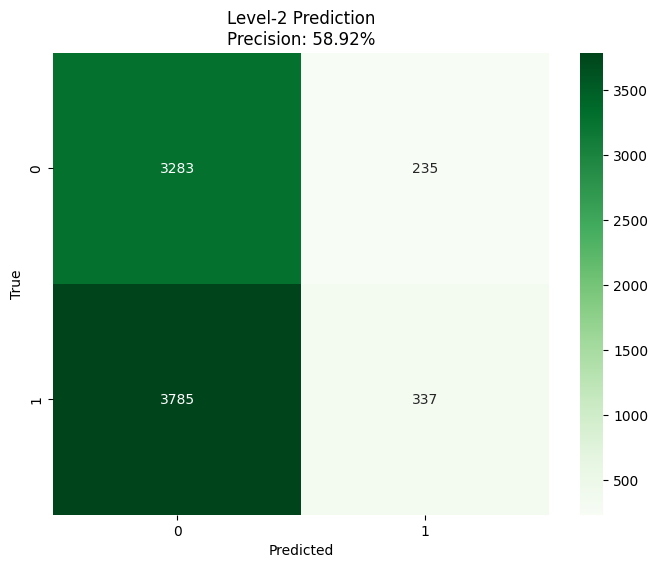

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import _Master_Model
reload(_Master_Model)
reload(_Utility)
from importlib import reload
from sklearn.svm import SVC
from _Utility import get_class_weights

shallow_master = _Master_Model.Master(
	model_depth		=	2
	,all_models 	=	[models, metamodel]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
	,lvl1_formatters=	[joblib.load('scaler/meta.joblib')]
)

X_blvl2 = X_val
y_blvl2 = y_val

pred_2 = shallow_master.master_predict(X_blvl2, mode='proba')
cm_vals = _Utility.get_cm_values(y_blvl2, pred_2)

_Utility.show_confusion_matrix(y_blvl2,pred_2,title=f'Level-1 Prediction\nPrecision: {round(precision_score(y_blvl2,pred_2)*100, 2)}%')

df = pd.DataFrame(X_blvl2)
df['score'] = cm_vals
df['target'] = y_blvl2
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)
#pd.set_option('display.max_rows',None)
co = df.corr()['target'].drop('target')
#print(co.sort_values())
p = co.nlargest(5).index.tolist()
n = co.nsmallest(5).index.tolist()
feats = p+n

df_pair = pd.DataFrame(X_blvl2)
df_pair = df_pair.iloc[kept_indices].reset_index(drop=True)
df_pair = df_pair.iloc[:, feats]

X_svm = df_pair.values
y_svm = df['target'].values

y_one = y_blvl2[kept_indices]

clf = SVC(kernel='linear',C=1.0,class_weight=_Utility.get_class_weights(y_one)).fit(X_svm, y_svm)

y_svmpred = pred_2#clf.predict(X_svm)
#'polishing' predictions based on if level-1 predicted (1)
for p in range(len(y_svmpred)):
	if(y_svmpred[p] == 1):
		y_svmpred[p] = clf.predict(X[p,feats].reshape(1, -1))

#_Utility.show_confusion_matrix(df['target'],y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_svm, y_svmpred)*100, 2)}%')
_Utility.show_confusion_matrix(y_blvl2,y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_blvl2, y_svmpred)*100, 2)}%')


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


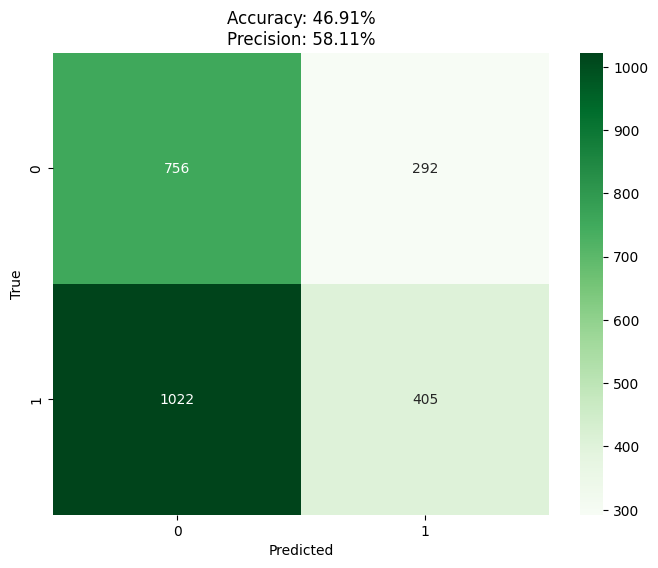

In [19]:
reload(_Master_Model)
reload(_Utility)
deep_master = _Master_Model.Master(
	model_depth		=	3
	,all_models 	=	[models, metamodel.model, clf]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
    ,lvl2_formatters=	[feats]
)

y_3pred = deep_master.master_predict(X_test)

_Utility.show_confusion_matrix(y_test, y_3pred, title=f'Accuracy: {_Utility.get_accuracy(y_test, y_3pred)}\nPrecision: {_Utility.get_precision(y_test, y_3pred)}')

In [23]:
import _Master_Model
from importlib import reload
reload(_Master_Model)
#deep_master = _Master_Model.Master(model_depth=3)
#deep_master.load_model('pre63p2-645-800')
deep_master.save_model()

Folder tree generated successfully.
PATH: tmp_model/level_0/model_0_0_0
keras saving complete
PATH: tmp_model/level_0/model_1_0_0
keras saving complete
PATH: tmp_model/level_0/model_2_0_0
keras saving complete
PATH: tmp_model/level_0/model_3_0_0
keras saving complete
PATH: tmp_model/level_0/model_4_0_0
keras saving complete
PATH: tmp_model/level_0/model_5_0_0
keras saving complete
PATH: tmp_model/level_0/model_6_0_0
keras saving complete
PATH: tmp_model/level_0/model_7_0_0
keras saving complete
helloooo


In [53]:
import _Time_Ensemble
import _Master_Model
import joblib
import _Utility

'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
reload(_Master_Model)
reload(_Time_Ensemble)
lstm_format = False
X_te, _, _, __,\
y_te, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

chronos_array = _Time_Ensemble.chronos_predict(X_te,                                                           
['pre63p2-645-800','models/m55','models/m60','models/m50','models/60_811_stdlvl0'])


loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
	19096 Samples Dropped.

Chronos: Predicting on Model #1 (pre63p2-645-800)
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Chronos: Predicting on Model #2 (models/m55)
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(2475, 8)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Chronos: Predicting on Model #3 (models/m60)
7

<class 'numpy.ndarray'>


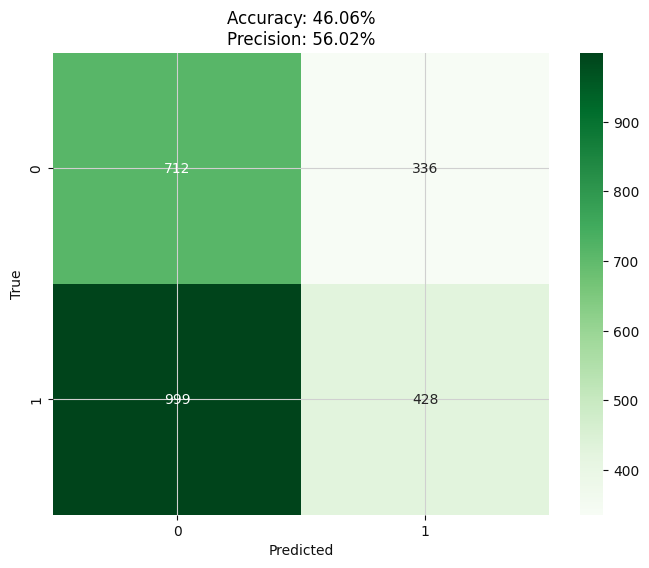

In [54]:
reload(_Utility)
reload(_Time_Ensemble)
print(type(chronos_array[0]))
t_pred	=	_Time_Ensemble.chronos_fusion(master_predictions=chronos_array, fusion_method='mv',vote_var=4)
_Utility.show_confusion_matrix(y_te, t_pred, title=f'Accuracy: {_Utility.get_accuracy(y_te, t_pred)}\nPrecision: {_Utility.get_precision(y_te, t_pred)}')

In [ ]:
#reload(_Utility)
#reload(_Time_Ensemble)
#vals = _Utility.graph_range(_Time_Ensemble.chronos_fusion, kw='vote_var', kw_range=range(0,5), show_graph=False, master_predictions=chronos_array,fusion_method='mv')
#scores = [precision_score(y_te, vals[i]) for i in range(0,5)]
#_Utility.plot_standard_line(scores, range(0,5))

In [ ]:
from _Utility import get_name_from_fss
get_name_from_fss(fss=feature_subsets,index=138)

'stchK60_spx'

loaded chunk 1 of size: 108200300 -> 55804341
concat chunks
concatted chunks
Success.
Size of dataset:	55804341
	19096 Samples Dropped.

Plotting Features: ['stchK10_spx', 'stchK30_spx']


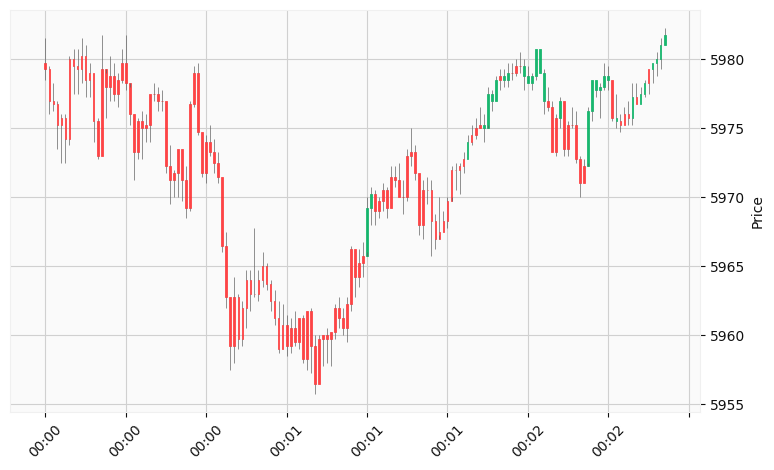

Plotting Features: ['stchK10_spx', 'stchK30_spx']


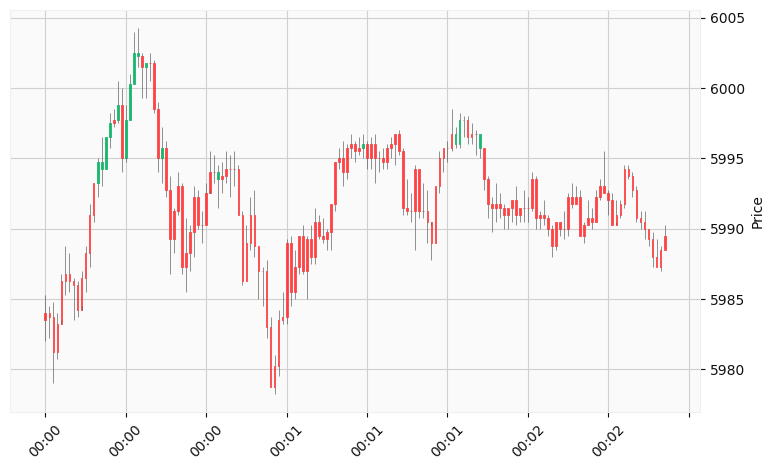

Plotting Features: ['stchK10_spx', 'stchK30_spx']


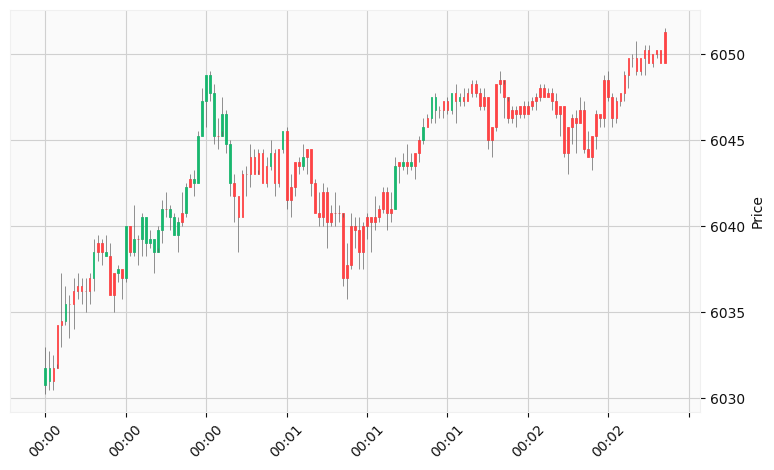

Plotting Features: ['stchK10_spx', 'stchK30_spx']


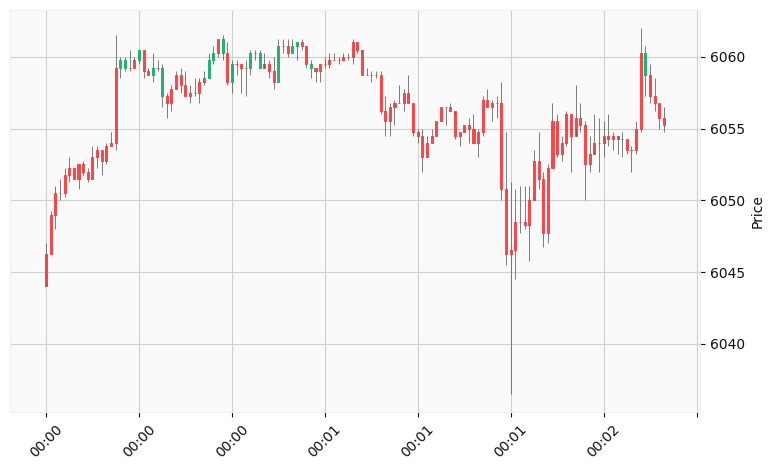

Plotting Features: ['stchK10_spx', 'stchK30_spx']


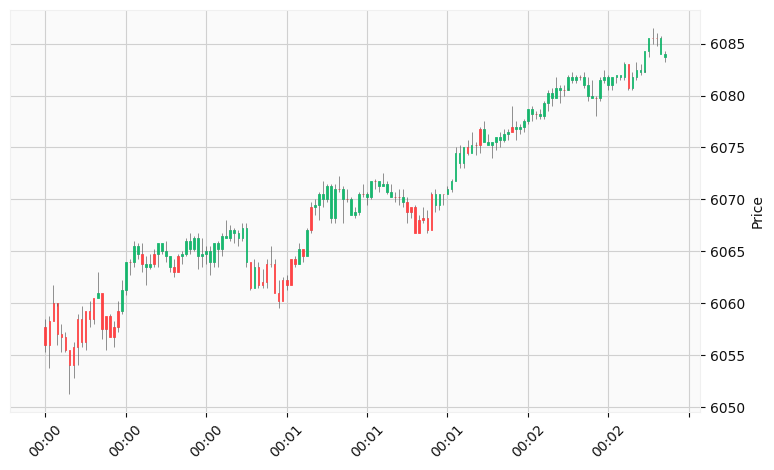

Plotting Features: ['stchK10_spx', 'stchK30_spx']


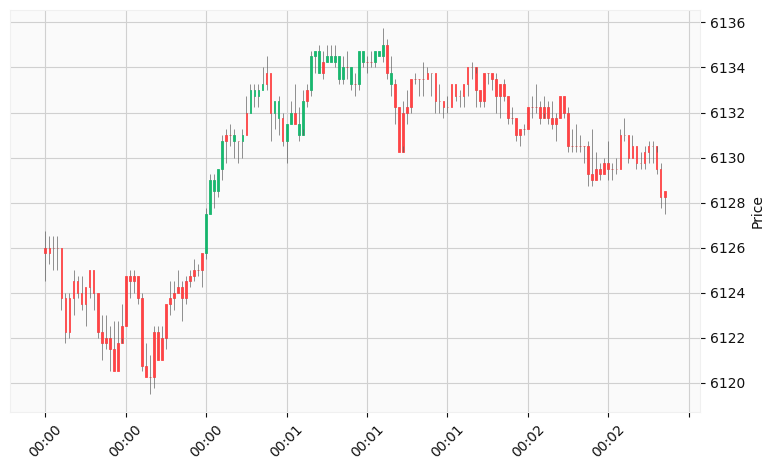

Plotting Features: ['stchK10_spx', 'stchK30_spx']


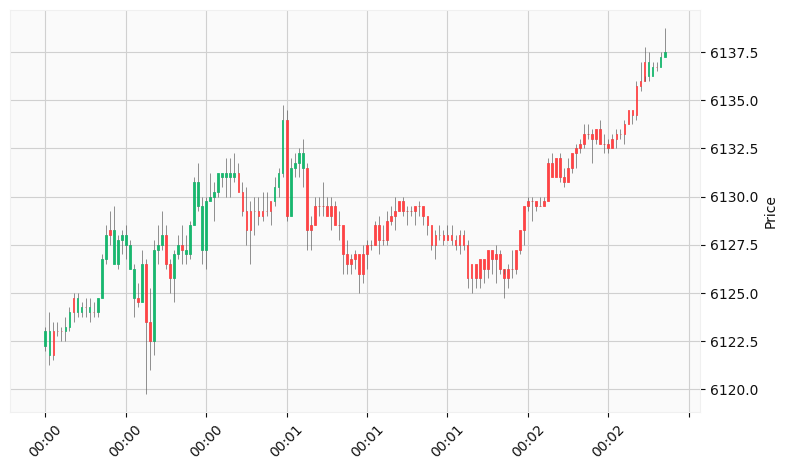

Plotting Features: ['stchK10_spx', 'stchK30_spx']


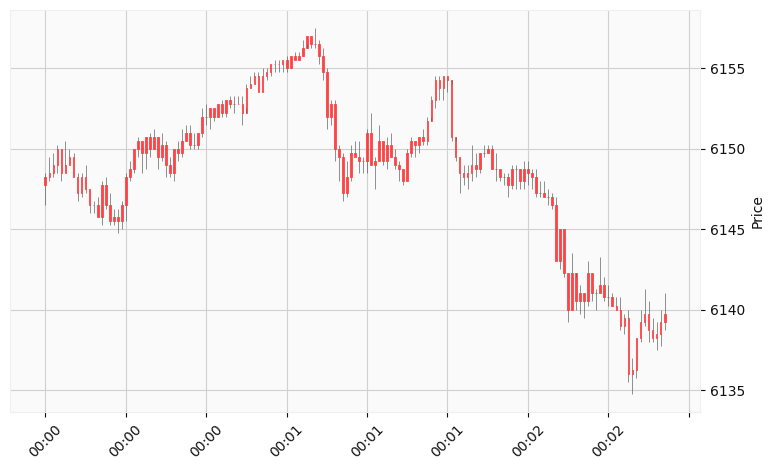

Plotting Features: ['stchK10_spx', 'stchK30_spx']


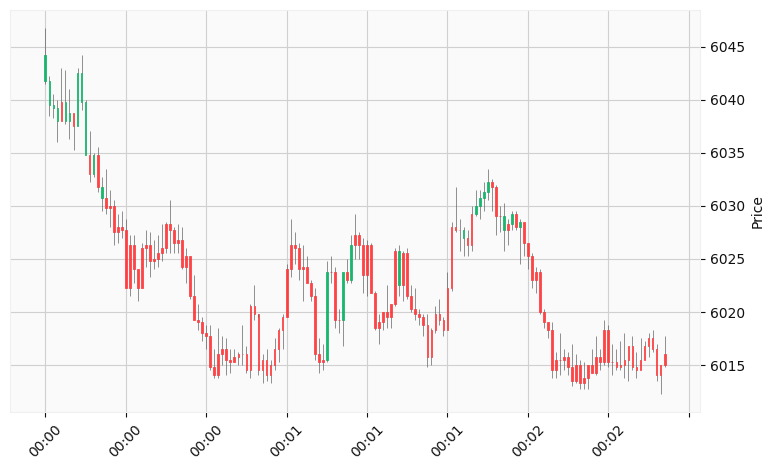

Plotting Features: ['stchK10_spx', 'stchK30_spx']


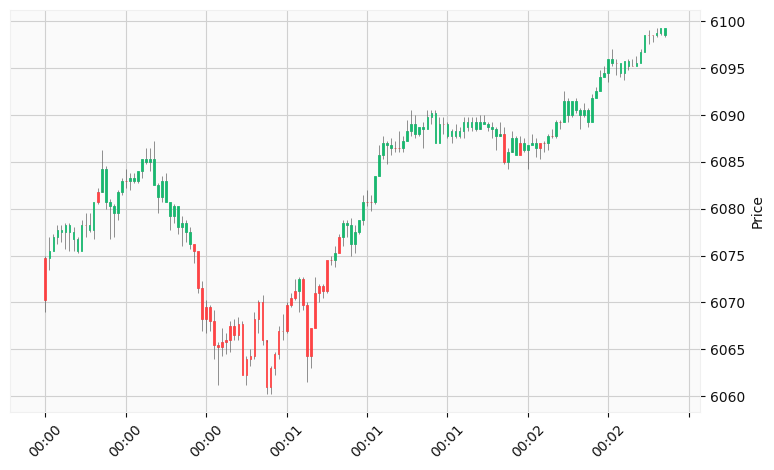

Plotting Features: ['stchK10_spx', 'stchK30_spx']


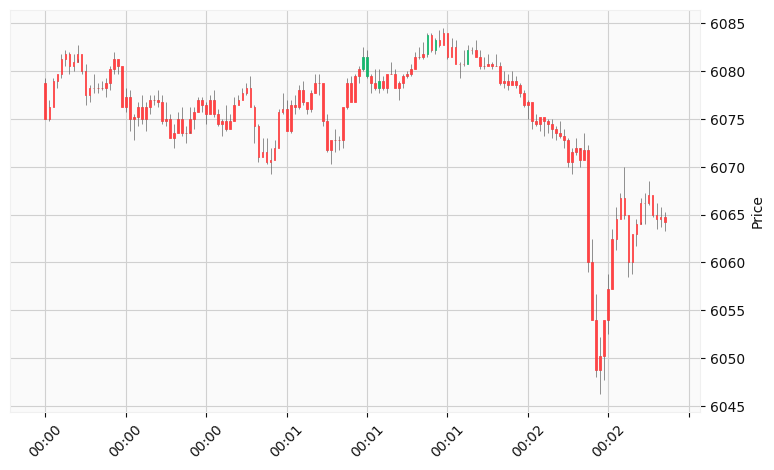

Plotting Features: ['stchK10_spx', 'stchK30_spx']


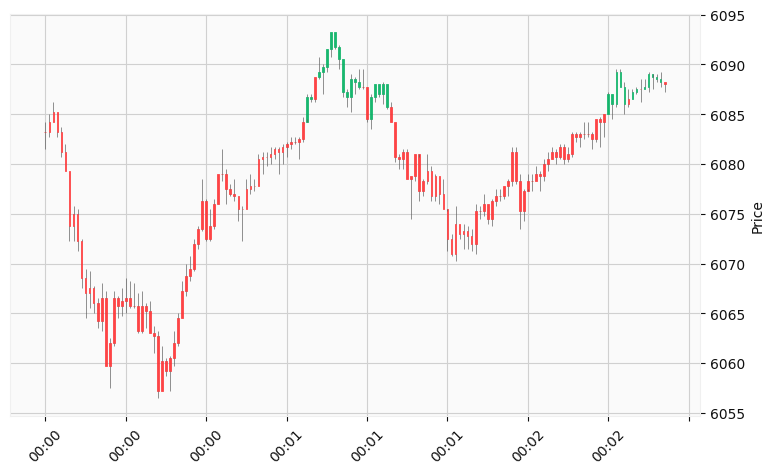

Plotting Features: ['stchK10_spx', 'stchK30_spx']


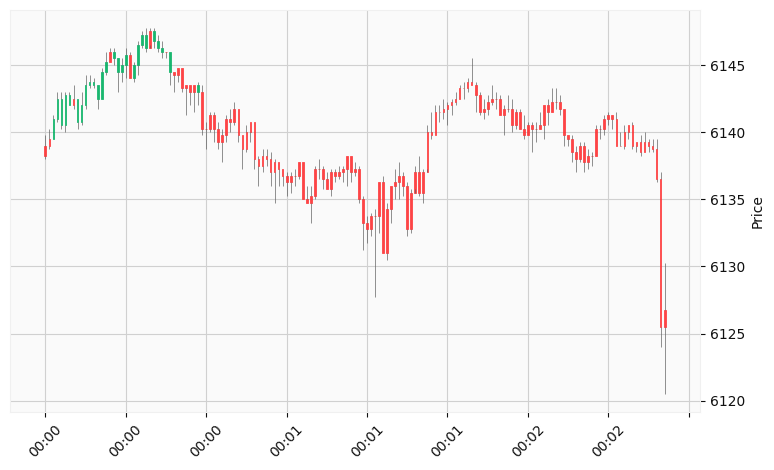

Plotting Features: ['stchK10_spx', 'stchK30_spx']


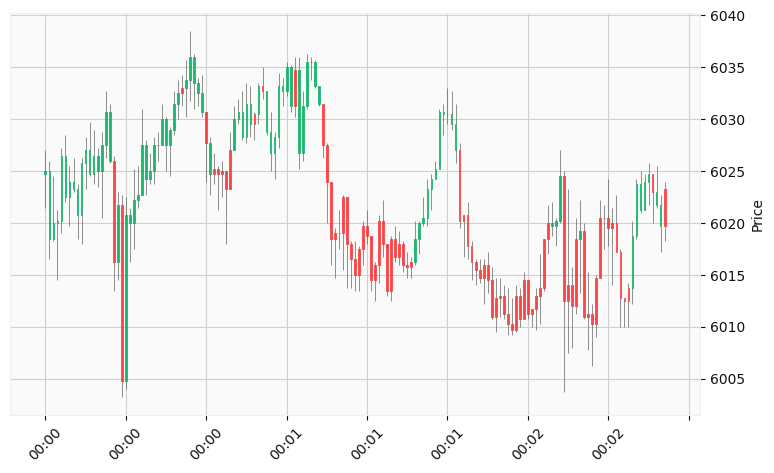

Plotting Features: ['stchK10_spx', 'stchK30_spx']


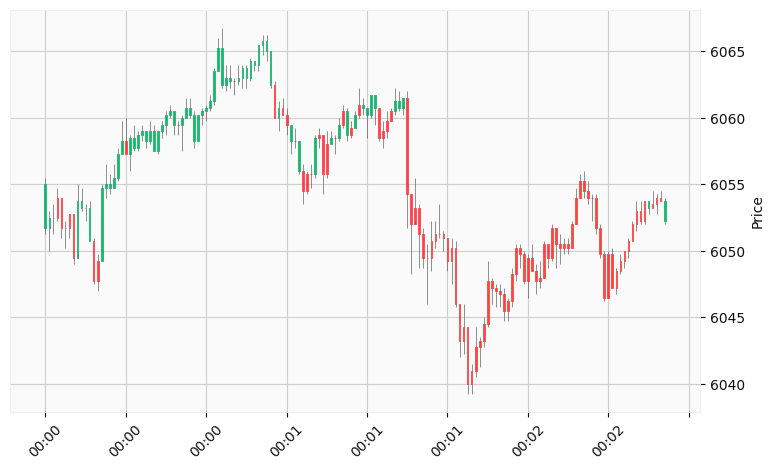

Plotting Features: ['stchK10_spx', 'stchK30_spx']


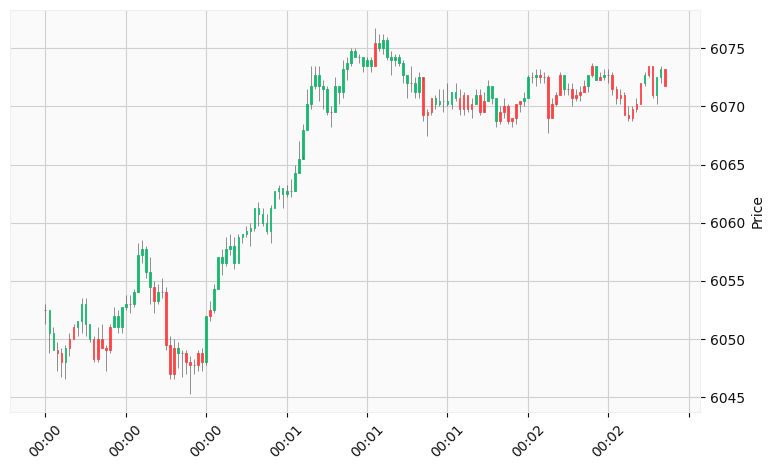

In [58]:
#showing chart of predictions
X_raw, _, _, __,\
y_raw, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'None'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

reload(_Utility)
_Utility.show_predictions_chart(X_raw=X_raw,predictions=t_pred, t_start=645, t_end=800
                                , add_chart=[128,132]
                                , fss=feature_subsets)